In [5]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import time
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Dark2').colors)
from getdist import plots, MCSamples
%matplotlib inline

In [6]:
import cv2

def smooth(x, smoothing_scale_arcmin=1, map_size_arcmin=210):
    """Smooth by Gaussian kernel."""
    # smoothing kernel width in pixels instead of arcmins
    map_size_pix = 512
    s = (smoothing_scale_arcmin * map_size_pix) / map_size_arcmin
    # cut off at: 6 sigma + 1 pixel
    # for large smooothing area and odd pixel number
    cutoff = 6 * int(s+1) + 1
    return cv2.GaussianBlur(x, ksize=(cutoff, cutoff), sigmaX=s, sigmaY=s)

def add_noise(x, ng):
    map_size_pix = 512
    x = x + torch.randn_like(x) * 0.4 / (2*ng*210**2/map_size_pix**2)**0.5
    return x

#Below is the code I used to measure the PS

#ng = 20
#l_edges = np.logspace(2, np.log10(12000.0), 19)
#convergence = ConvergenceMap(smooth(add_noise(data, ng)), 3.5 * u.deg)
#PS = convergence.powerSpectrum(l_edges)[1]

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import LinearNDInterpolator

ng = 100

# load precalculated PS of all training data
logPS = np.log(np.load('/global/cscratch1/sd/biwei/WL_baryon_2176/PS18_ng%d_smoothing.npy' % ng)) #75 * 2048 * 36 * 18
logPS_mean = np.mean(logPS, 2) #75 * 2048 * 18

#load cosmological parameters and baryon parameters
cosmology_param = np.log(np.load('/global/cscratch1/sd/biwei/WL_baryon_2176/cosmologies.npy')) #75 * 2
baryon_param = np.log(np.loadtxt('/global/cscratch1/sd/biwei/WL_baryon_2176/baryonic_parameters.txt')) #2048 * 4

# calculate 2nd order features of baryon parameters
poly = PolynomialFeatures(degree=2, include_bias=False)
features = poly.fit_transform(baryon_param) #2048 * 14

# fit 2nd polynomials to the mean PS for 75 cosmologies
poly_reg_model = [LinearRegression() for _ in range(75)]
for i in range(75):
    poly_reg_model[i].fit(features, logPS_mean[i])

# calculate covariance matrix for 75 cosmologies
covariance = np.zeros((75, 18, 18))
for i in range(75):
    mean = poly_reg_model[i].predict(features)
    delta = (logPS[i] - mean[:,None,:]).reshape(-1,18)
    covariance[i] = delta.T @ delta / (len(delta)-18-2) / 128. # 128 maps 

# linearly interpoate covariance matrix
cov_interp = LinearNDInterpolator(cosmology_param, covariance)

# uniform prior within the convex hull of training data
logprior_interp = LinearNDInterpolator(cosmology_param, np.zeros((75,1)), fill_value=-np.inf)

# prior bounds
bounds = np.array([[0.4, 1.1], [0.2, 0.6], [5.9e11, 4.4e15], [9.3e10, 1.1e13], [0.12, 2.7], [0.026, 3.8]]) #6 * 2
bounds = np.log(bounds)


def log_prior(x):
    # log prior is 0 because we already use log parameter?
    logprior = logprior_interp(x[:,:2]).flatten()
    select = np.zeros(len(x), dtype=bool)
    for i in range(6):
        select |= x[:,i] < bounds[i,0]
        select |= x[:,i] > bounds[i,1]
    logprior[select] = -np.inf
    return logprior


def log_like(x, logPS):
    #covariance matrix
    cov = cov_interp(x[:,:2])  #nchain * 18 * 18
    cov_inv = np.linalg.inv(cov)
    
    #mean PS
    baryon = x[:,2:]
    features = poly.fit_transform(baryon)
    mean = np.array([poly_reg_model[i].predict(features) for i in range(75)]) #75 * nchain * 18
    mean_interp = [LinearNDInterpolator(cosmology_param, mean[:,i,:]) for i in range(len(x))]
    meanPS = np.array([mean_interp[i](x[i,:2].reshape(1,2))[0] for i in range(len(x))]) #nchain * 18
    
    delta = logPS - meanPS
    
    return -0.5 * np.linalg.slogdet(cov)[1] - 1. * np.einsum("ni,nij,nj->n", delta, cov_inv, delta)


def logp_posterior(x, logPS):
    if x.shape[1] == 2:
        baryon = np.log(np.array([4.583333333333333e13, 1.198611111111111e12, 0.54, 0.12])).reshape(1,4)
        baryon = np.repeat(baryon, len(x), 0)
        x = np.concatenate((x, baryon), 1)
    logp = log_prior(x)
    select = np.isfinite(logp)
    if np.sum(select) > 0:
        logp[select] = logp[select] + log_like(x[select], logPS)
    return logp

In [41]:
# load precalculated PS of the test data.
logPS_val = np.load('/global/cscratch1/sd/biwei/WL_baryon_2176/PS18_ref_ng%d_smoothing_seed738.npy'%ng)

# Calculate the mean PS of the 128 test maps. This corresponds to a survey with area 128 * 3.5^2 = 1568
logPS_val = np.mean(logPS_val, 0)

# fiducial baryon

In [38]:
#MCMC
import emcee

nwalkers = 4
ndim = 2

#initial points
x0 = np.random.rand(nwalkers, ndim) * (bounds[:2,1] - bounds[:2,0]) + bounds[:2,0]
select = np.isfinite(logp_posterior(x0, logPS_val))
while not select.all():
    x0[~select] = np.random.rand(np.sum(~select), ndim) * (bounds[:2,1] - bounds[:2,0]) + bounds[:2,0]
    select = np.isfinite(logp_posterior(x0, logPS_val))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp_posterior, args=[logPS_val,], vectorize=True)

t = time.time()
#warm-up
state = sampler.run_mcmc(x0, 20000)
sampler.reset()
print(time.time()-t)

#MCMC
t = time.time()
sampler.run_mcmc(state, 100000)
print(time.time()-t)

318.62393021583557
1572.8868761062622


## ng=100 fac=1 fiducial baryon

Removed no burn in
26403.973484136677 1
3.7873087571489687e-05


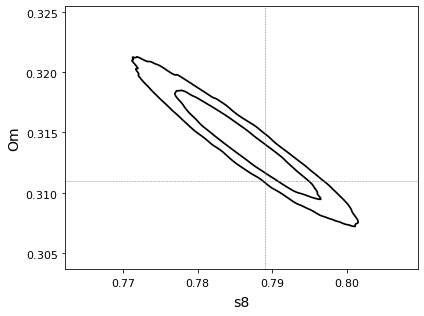

In [39]:
samples = np.copy(sampler.get_chain(flat=True))
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

## ng=50 fac=1 fiducial baryon

Removed no burn in
23638.54814683167 1
4.23037825245639e-05


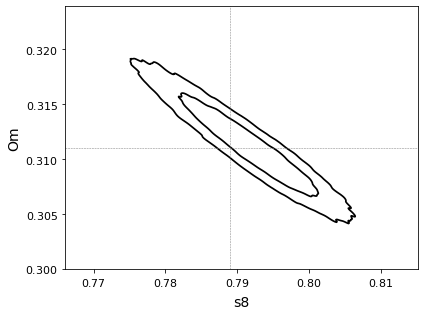

In [35]:
samples = np.copy(sampler.get_chain(flat=True))
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

## ng=20 fac=1 fiducial baryon

Removed no burn in
14025.658856869086 1
7.129789838787136e-05


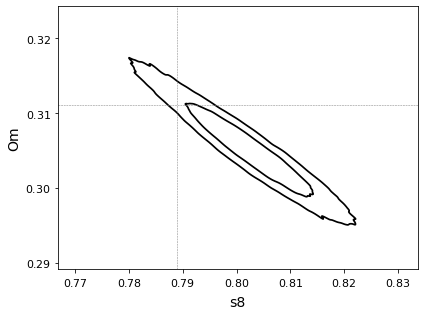

In [31]:
samples = np.copy(sampler.get_chain(flat=True))
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

# marginalize over baryon

In [42]:
#MCMC
import emcee

nwalkers = 12
ndim = 6

#initial points
x0 = np.random.rand(nwalkers, ndim) * (bounds[:,1] - bounds[:,0]) + bounds[:,0]
select = np.isfinite(logp_posterior(x0, logPS_val))
while not select.all():
    x0[~select] = np.random.rand(np.sum(~select), ndim) * (bounds[:,1] - bounds[:,0]) + bounds[:,0]
    select = np.isfinite(logp_posterior(x0, logPS_val))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp_posterior, args=[logPS_val,], vectorize=True)

t = time.time()
#warm-up
state = sampler.run_mcmc(x0, 20000)
sampler.reset()
print(time.time()-t)

#MCMC
t = time.time()
sampler.run_mcmc(state, 100000)
print(time.time()-t)

399.16726064682007
1971.3142642974854


## ng=100 fac=1

Removed no burn in


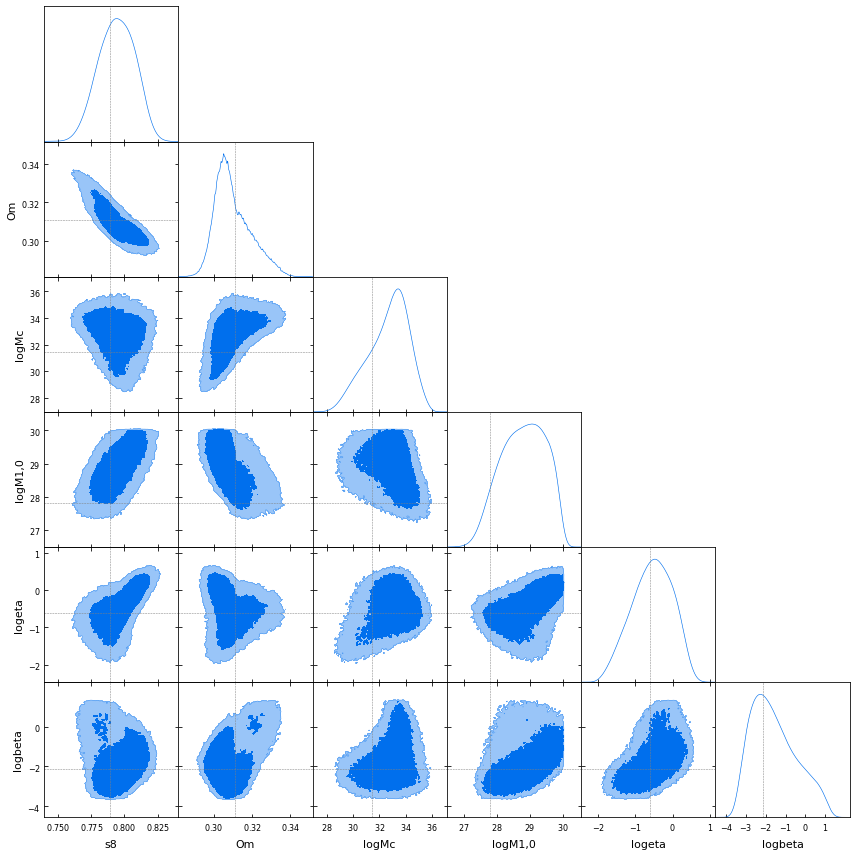

In [20]:
param_true = np.array([0.789, 0.311, 4.583333333333333e13, 1.198611111111111e12, 0.54, 0.12])
param_true[2:] = np.log(param_true[2:])

samples = np.copy(sampler.get_chain(flat=True))
samples[:,:2] = np.exp(samples[:,:2])
samples = MCSamples(samples=samples, names=['s8', 'Om', 'logMc', 'logM1,0', 'logeta', 'logbeta'])

g = plots.get_subplot_plotter()
g.triangle_plot([samples, ], filled=True, markers={'s8': param_true[0], 'Om': param_true[1], 'logMc': param_true[2], 'logM1,0': param_true[3], 'logeta': param_true[4], 'logbeta': param_true[5]})

Removed no burn in


2093.889774397271 0
0.00047758005804668076


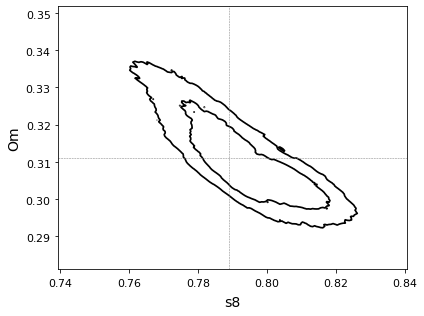

In [22]:
samples = np.copy(sampler.get_chain(flat=True)[:,:2])
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

## ng=50 fac=1

Removed no burn in


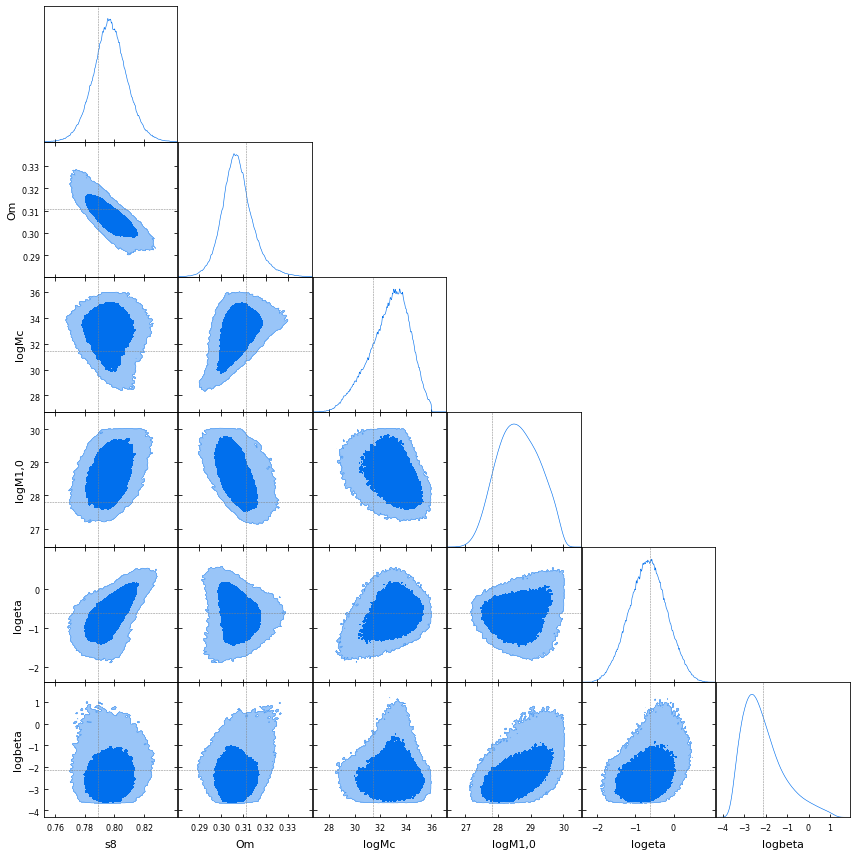

In [15]:
param_true = np.array([0.789, 0.311, 4.583333333333333e13, 1.198611111111111e12, 0.54, 0.12])
param_true[2:] = np.log(param_true[2:])

samples = np.copy(sampler.get_chain(flat=True))
samples[:,:2] = np.exp(samples[:,:2])
samples = MCSamples(samples=samples, names=['s8', 'Om', 'logMc', 'logM1,0', 'logeta', 'logbeta'])

g = plots.get_subplot_plotter()
g.triangle_plot([samples, ], filled=True, markers={'s8': param_true[0], 'Om': param_true[1], 'logMc': param_true[2], 'logM1,0': param_true[3], 'logeta': param_true[4], 'logbeta': param_true[5]})

Removed no burn in


3149.2286620358163 0
0.00031753807275256756


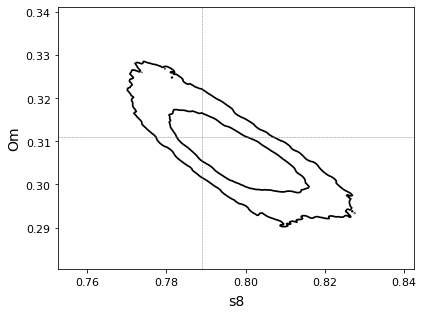

In [16]:
samples = np.copy(sampler.get_chain(flat=True)[:,:2])
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

## ng=20 fac=1

Removed no burn in


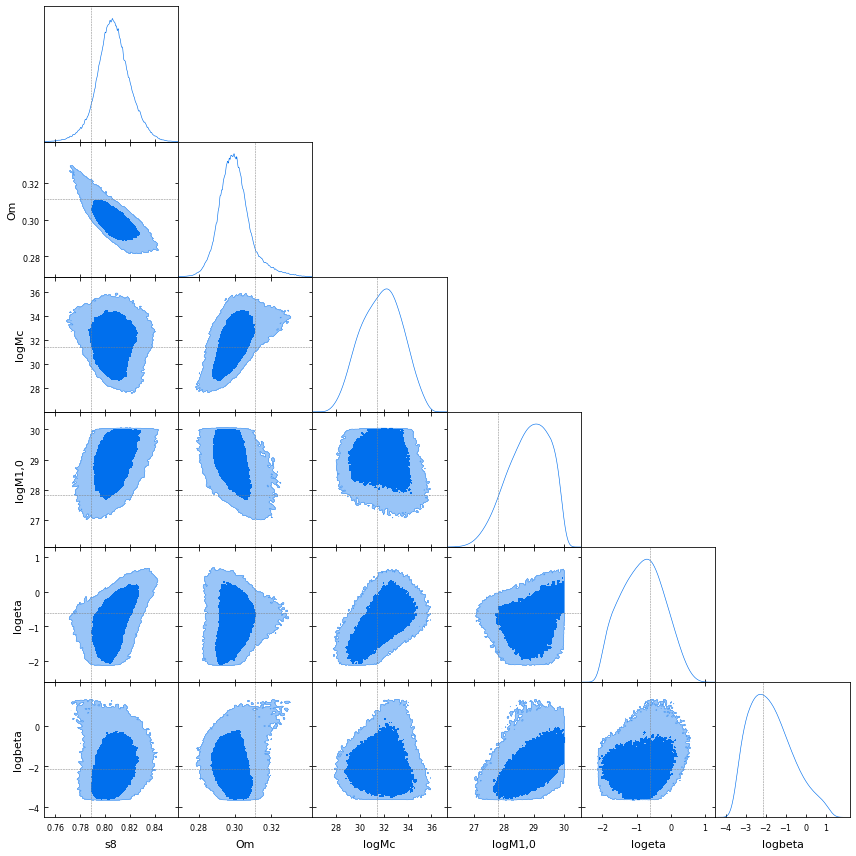

In [10]:
param_true = np.array([0.789, 0.311, 4.583333333333333e13, 1.198611111111111e12, 0.54, 0.12])
param_true[2:] = np.log(param_true[2:])

samples = np.copy(sampler.get_chain(flat=True))
samples[:,:2] = np.exp(samples[:,:2])
samples = MCSamples(samples=samples, names=['s8', 'Om', 'logMc', 'logM1,0', 'logeta', 'logbeta'])

g = plots.get_subplot_plotter()
g.triangle_plot([samples, ], filled=True, markers={'s8': param_true[0], 'Om': param_true[1], 'logMc': param_true[2], 'logM1,0': param_true[3], 'logeta': param_true[4], 'logbeta': param_true[5]})

Removed no burn in


2190.553816385836 1
0.00045650556152502386


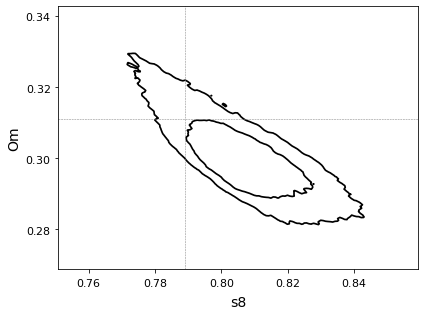

In [11]:
samples = np.copy(sampler.get_chain(flat=True)[:,:2])
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)

## ng=20 fac=0.5

Removed no burn in


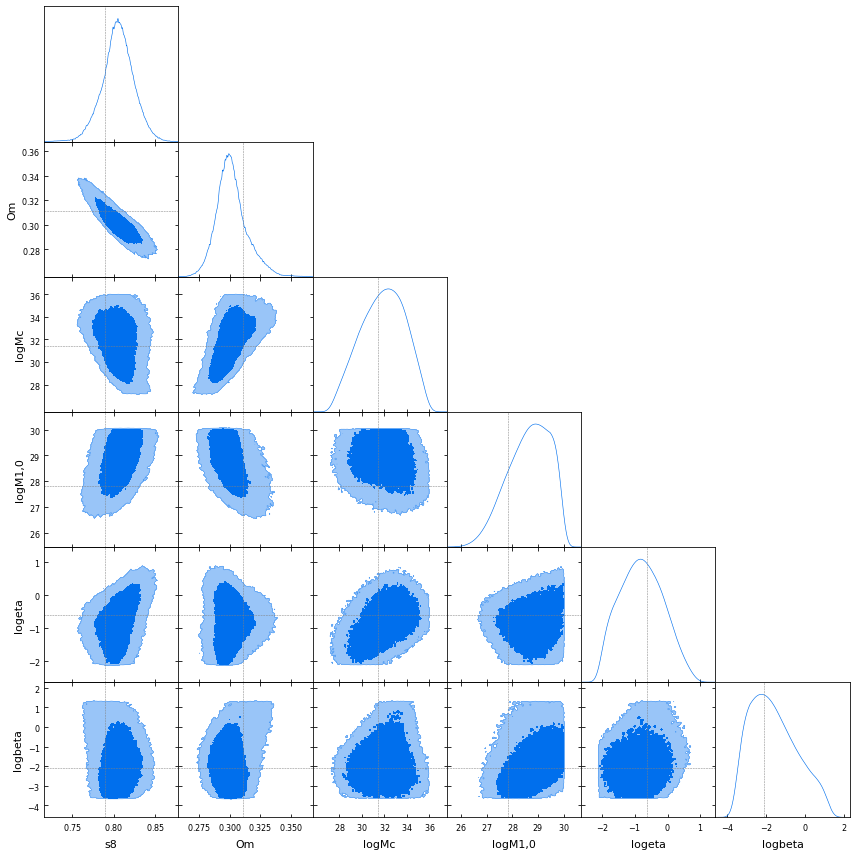

In [30]:
param_true = np.array([0.789, 0.311, 4.583333333333333e13, 1.198611111111111e12, 0.54, 0.12])
param_true[2:] = np.log(param_true[2:])

samples = np.copy(sampler.get_chain(flat=True))
samples[:,:2] = np.exp(samples[:,:2])
samples = MCSamples(samples=samples, names=['s8', 'Om', 'logMc', 'logM1,0', 'logeta', 'logbeta'])

g = plots.get_subplot_plotter()
g.triangle_plot([samples, ], filled=True, markers={'s8': param_true[0], 'Om': param_true[1], 'logMc': param_true[2], 'logM1,0': param_true[3], 'logeta': param_true[4], 'logbeta': param_true[5]})

Removed no burn in
1264.6668220836443 0
0.0007907220957630693


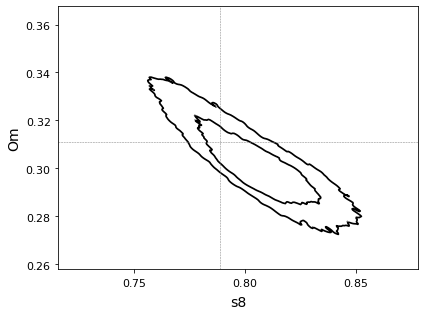

In [37]:
samples = np.copy(sampler.get_chain(flat=True)[:,:2])
samples = np.exp(samples)
samples = MCSamples(samples=samples, names=['s8', 'Om'])


g = plots.get_single_plotter()
_, _, FoM, flag = g.plot_2d([samples, ], 's8', 'Om', return_FoM=True, xtrue=0.789, ytrue=0.311)
g.add_x_marker(0.789)
g.add_y_marker(0.311)
A = 1. / FoM[0]
print(A)